In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
# import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
tf.random.set_seed(42)

In [3]:
#Getting the data
batch_size = 128
target_size = (48,48)
train_dir = "fer2013plus/fer2013plus/fer2013/train/"
test_dir = "fer2013plus/fer2013plus/fer2013/test/"
train_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               horizontal_flip=True,
                                                               validation_split=0.2)
train_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size, 
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='training')
validation_ds = train_dataGenerator.flow_from_directory(train_dir,
                                                        batch_size=batch_size,
                                                        target_size=target_size,
                                                        shuffle=True,
                                                        class_mode='categorical',
                                                        color_mode="grayscale", 
                                                        subset='validation')

test_dataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
test_ds = test_dataGenerator.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  target_size=target_size,
                                                  shuffle=True,
                                                  color_mode="grayscale", 
                                                  class_mode="categorical")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [4]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        
        kernel_initializer='he_normal',  
        
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,  # Increasing learning capacity and feature extraction
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)

    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,   # 128 input neurons
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer',
        kernel_initializer=tf.keras.initializers.HeNormal()
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [5]:
model = build_dcnn(input_shape=(48,48,1), num_classes=8)
model.summary() 

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0      

In [6]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(0.01),
             metrics=["accuracy"])

In [7]:
#Callback functions
early_stopping = EarlyStopping(
    monitor='val_loss',    
    min_delta=0.00001,      
    patience=8,            
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  #val_loss no overfitting   
    min_delta=0.0001,  
    mode="min",
    factor=0.5,                 
    patience=6,                 
    min_lr=1e-7,                
    verbose=1                   
)

checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', 
                         verbose=1, save_best_only=True, mode='max')

In [8]:
# aug_datagen = ImageDataGenerator(
# #     width_shift_range=0.15,
# #     height_shift_range=0.15,
# #     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
#     validation_split=0.2
# )

In [9]:
# aug_train_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="training")
# aug_validation_ds = aug_datagen.flow_from_directory(train_dir,
#                                                target_size=target_size,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale",
#                                               class_mode="categorical",
#                                               subset="validation")

In [11]:
#Fitting the data
import time
start = time.time()
history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    validation_steps=int(0.25*len(test_ds)),
                   validation_data = validation_ds,
                   epochs=100,
                   callbacks=[early_stopping, lr_scheduler, checkpoint])
end = time.time()
print(end-start)

Epoch 1/100


178/178 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.4974
Epoch 1: val_accuracy improved from -inf to 0.53460, saving model to model.h5
178/178 [==============================] - 28s 115ms/step - loss: 1.4564 - accuracy: 0.4974 - val_loss: 1.3577 - val_accuracy: 0.5346 - lr: 0.0100
Epoch 2/100
  1/178 [..............................] - ETA: 22s - loss: 1.1914 - accuracy: 0.5391

/home/ujjwal/miniconda3/envs/tf-nightly/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.6487
Epoch 2: val_accuracy improved from 0.53460 to 0.62667, saving model to model.h5
178/178 [==============================] - 18s 102ms/step - loss: 0.9979 - accuracy: 0.6487 - val_loss: 1.0393 - val_accuracy: 0.6267 - lr: 0.0100
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6997
Epoch 3: val_accuracy improved from 0.62667 to 0.67355, saving model to model.h5
178/178 [==============================] - 18s 102ms/step - loss: 0.8482 - accuracy: 0.6997 - val_loss: 0.9190 - val_accuracy: 0.6735 - lr: 0.0100
Epoch 4/100
178/178 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.7253
Epoch 4: val_accuracy improved from 0.67355 to 0.73047, saving model to model.h5
178/178 [==============================] - 18s 103ms/step - loss: 0.7778 - accuracy: 0.7253 - val_loss: 0.7743 - val_accuracy: 0.7305 - lr: 0.0100
Epoch 5/100
178/178 [================

In [10]:
model.evaluate(test_ds)

56/56 [==============================] - 7s 118ms/step - loss: 0.5810 - accuracy: 0.8065


[0.5810478329658508, 0.8064516186714172]

In [41]:
history.history["val_accuracy"][-1]

0.8142403960227966

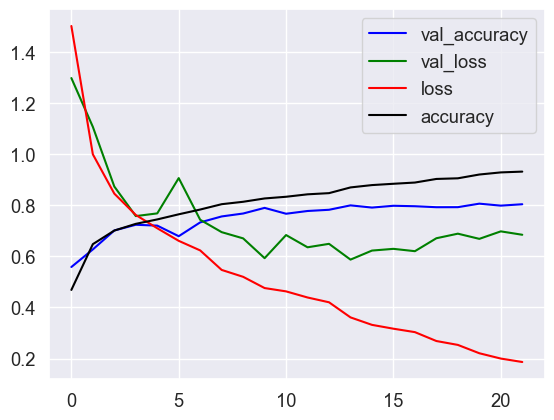

In [100]:
plt.plot(history.history["val_accuracy"], color="blue")
plt.plot(history.history["val_loss"], color="green")
plt.plot(history.history["loss"], color="red")
plt.plot(history.history["accuracy"], color="black")
plt.legend(["val_accuracy","val_loss","loss", "accuracy"])
plt.show()

In [77]:
def conf_mat(y_test,y_pred,labels=['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (30,30))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 20}, fmt='g')

In [110]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=-1)

2023-08-02 16:44:42.999569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 7s 114ms/step


56/56 [==============================] - 6s 113ms/step


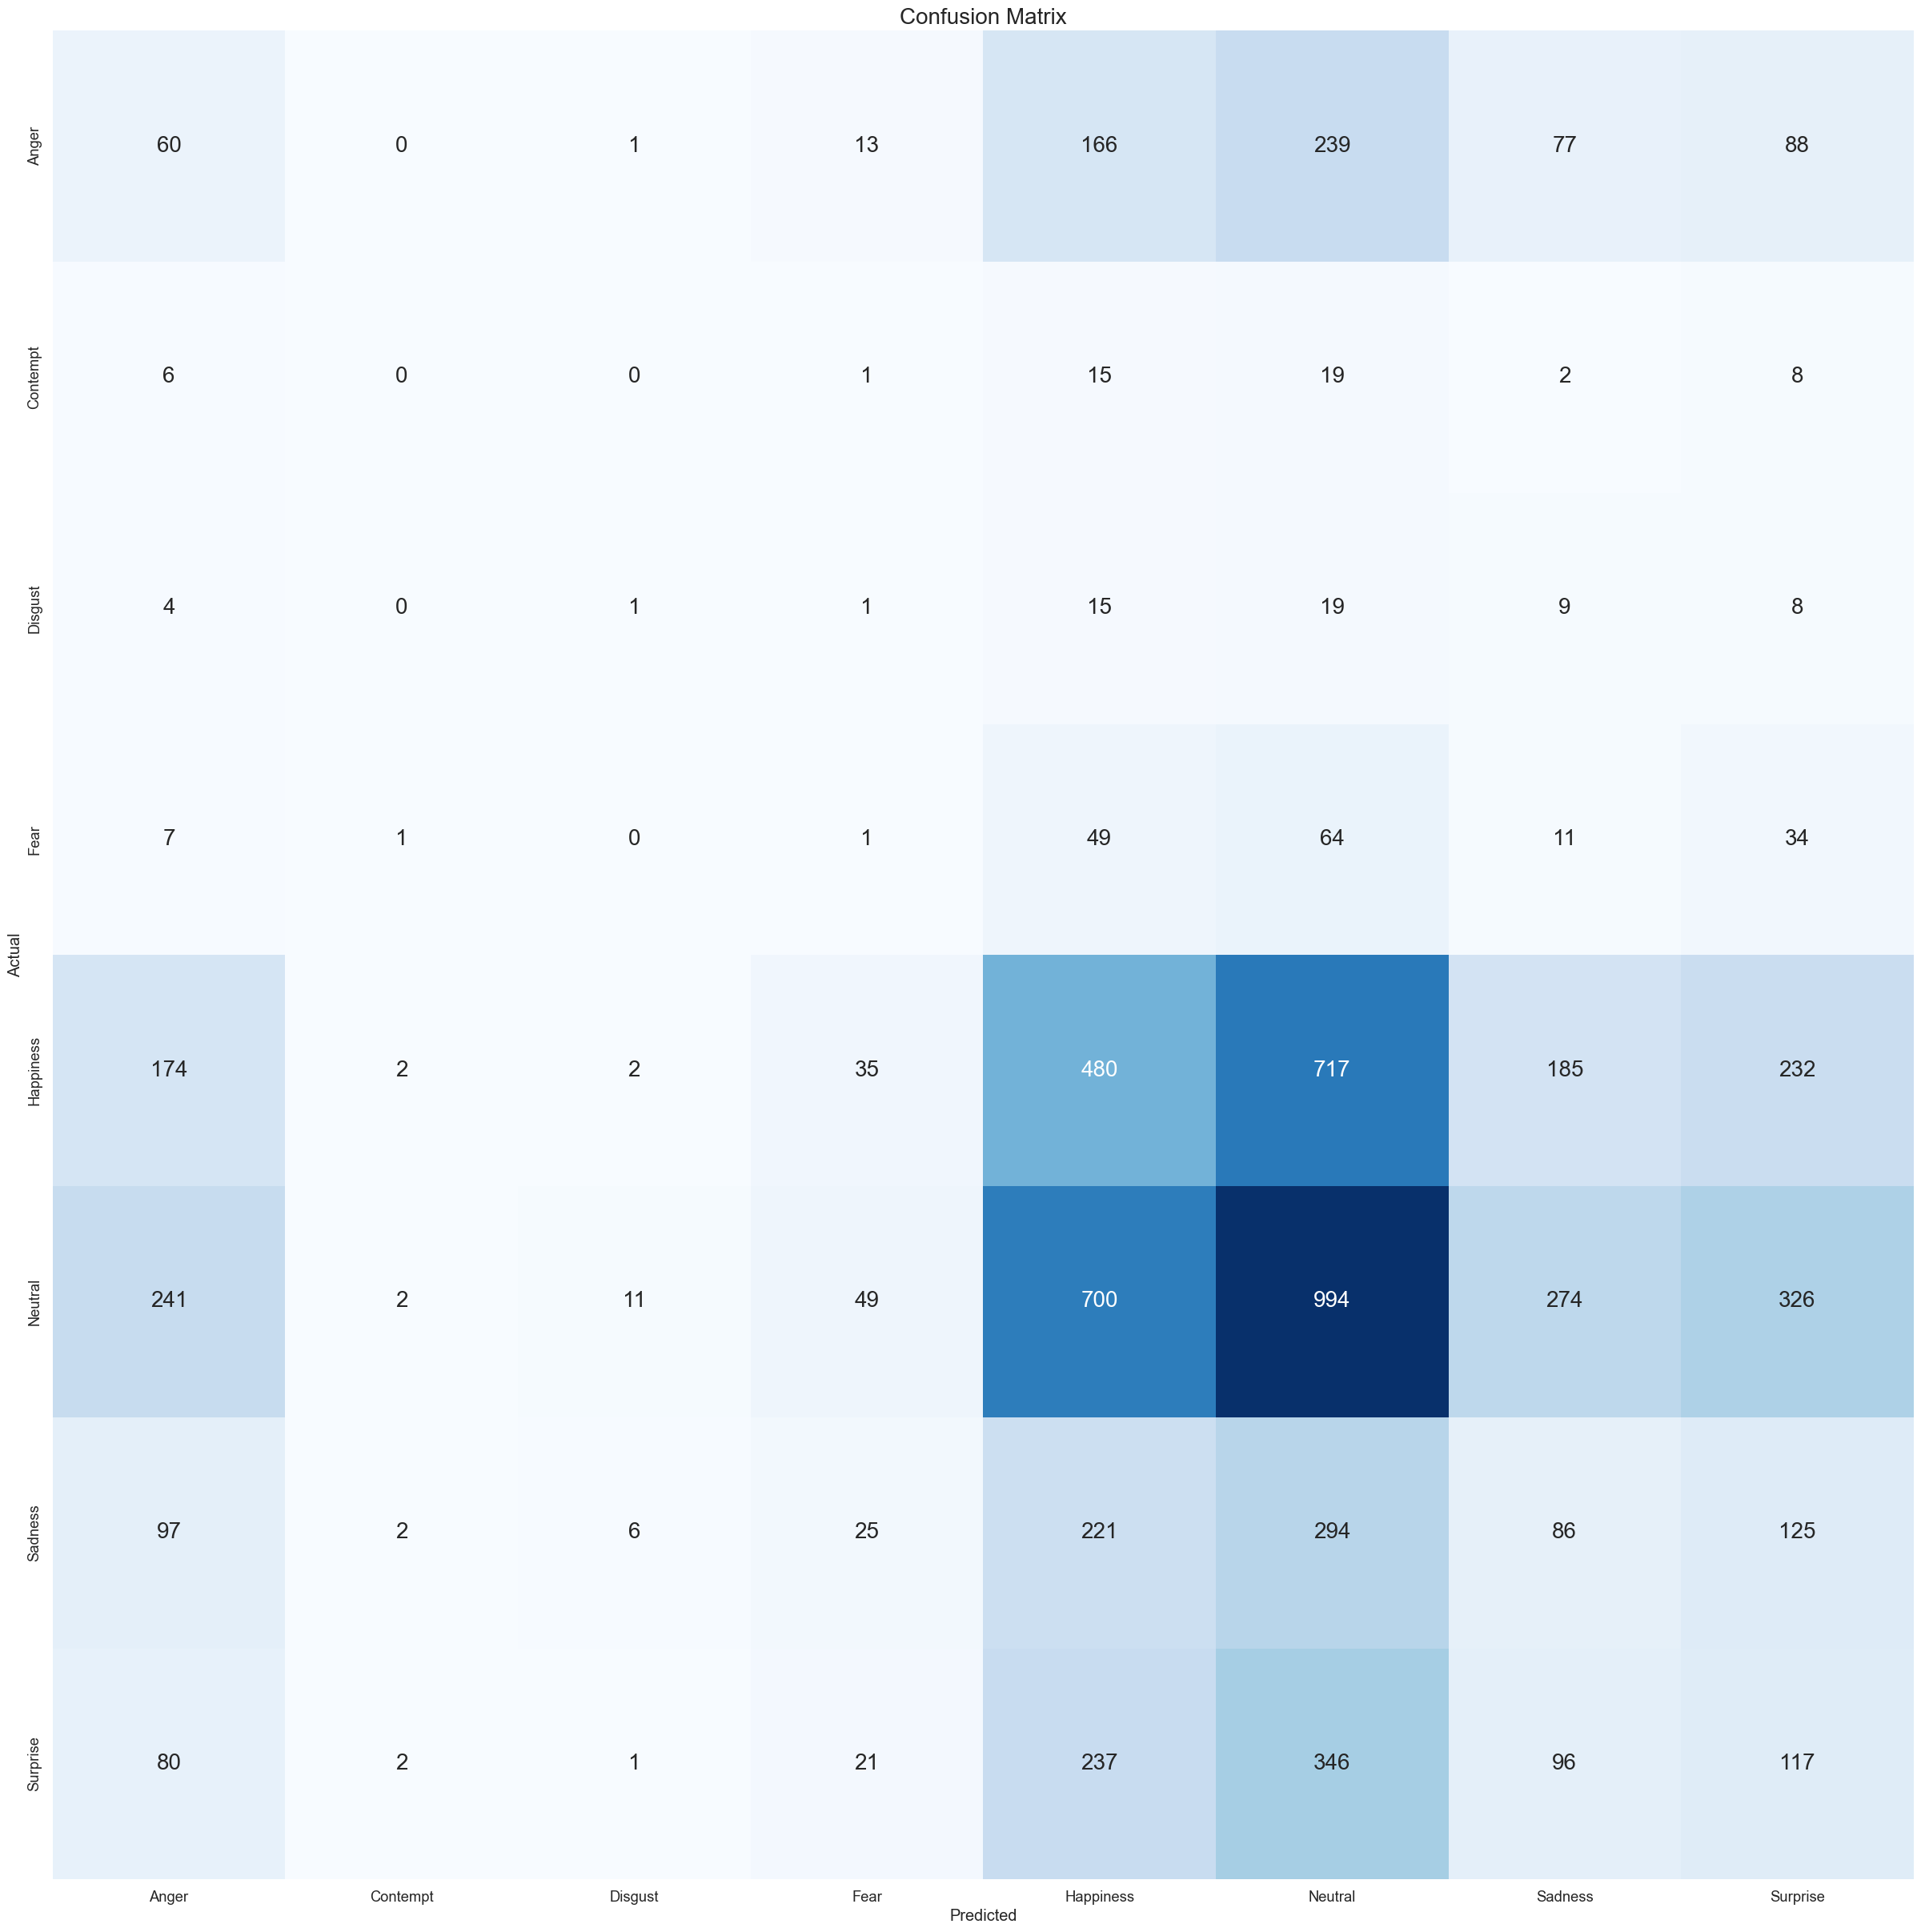

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat(test_ds.labels, y_pred)

In [111]:
y_pred

array([4, 4, 4, ..., 4, 5, 0])

In [114]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_ds.labels, y_pred, average="weighted")
# model_results = {#"accuracy": model_accuracy,
#                   "precision": model_precision,
#                   "recall": model_recall,
#                   "f1": model_f1}
model_precision, model_recall, model_f1

(0.2394567687143107, 0.25116213551204397, 0.24486687898142673)

4

In [ ]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

In [ ]:
model.save("high")

In [ ]:
x_test,y_test = next(test_ds)
predict = model.predict(x_test)
class_labels = test_ds.class_indices
class_labels = {v:k for k,v in class_labels.items()}
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
train_features = model.predict(train_ds)
train_ft = train_features.reshape(train_features.shape[0], -1)
validation_features = model.predict(validation_ds)
validation_ft = validation_features.reshape(validation_features.shape[0],-1)
test_features = model.predict(test_ds)
test_ft = test_features.reshape(test_features.shape[0],-1)

In [ ]:
train_ft.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_ft, train_ds.labels)

In [ ]:
rf_classifier.score(test_ft, test_ds.labels)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(train_ft,train_ds.labels)

y_pred = svm_classifier.predict(test_ft)
y_pred

In [ ]:
svm_classifier.evaluate(test_ft)